In [1]:
! pip3 install evaluate
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(next((root for root, _, files in os.walk(".") if "dsait4090_project_location" in files), "."))
    print(f'Google Colab: {os.getcwd()}')
except ImportError:
    print(f'Local: {os.getcwd()}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/drive
Google Colab: /content/drive/Othercomputers/macbook_pro/

In [2]:
import logging
import torch

from src.classification_training import ClassificationTraining
from src.common import read_data, QTDataset, get_device
from src.models.bart_large_mnli import BartLargeMnliTokenizer, BartLargeMnliClassifier
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset
from tqdm.auto import tqdm
from torch import nn

CATEGORIES = ["statistical", "temporal", "interval", "comparison"]

logging.basicConfig(level=logging.ERROR)

device = get_device()

label_endocer = LabelEncoder()
label_endocer.fit(CATEGORIES)
label_endocer.classes_

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CUDA: 1, use NVIDIA A100-SXM4-40GB


array(['comparison', 'interval', 'statistical', 'temporal'], dtype='<U11')

In [3]:
model = BartLargeMnliClassifier(labels_count=len(CATEGORIES)).to(device)
tokenizer = BartLargeMnliTokenizer()

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
train_claims = read_data('raw_data/train_claims.json')
val_claims = read_data('raw_data/val_claims.json')
test_claims = read_data('raw_data/test_claims.json')

def build_dataset(claims: QTDataset) -> TensorDataset:
    # features
    features = [claim['claim'] for claim in claims]
    input_tokens = []
    attention_masks = []

    for feature in tqdm(features):
        input_token, attention_mask = tokenizer(feature)
        input_tokens.append(input_token)
        attention_masks.append(attention_mask)

    input_tokens = torch.cat(input_tokens)
    attention_masks = torch.cat(attention_masks)

    # labels
    labels = [claim['taxonomy_label'].strip() for claim in claims]
    encoded_labels = torch.tensor(label_endocer.transform(labels))

    return TensorDataset(input_tokens, attention_masks, encoded_labels)

train_dataset = build_dataset(train_claims)
val_dataset = build_dataset(val_claims)
test_dataset = build_dataset(test_claims)

  0%|          | 0/9935 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/3084 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/2495 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [5]:
training = ClassificationTraining(
    model_name="routing_model",
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    model=model,
    optimizer=torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8),
    loss_function=nn.CrossEntropyLoss(),
    batch_size=16,
    device=device,
    random_state=0
)


Starting new training from epoch 1

EPOCH 1


train:   0%|          | 0/621 [00:00<?, ?it/s]

BartModel is using BartSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.530 | 78.89
   eval:  0.449 | 82.71
Saved best model: best_model_01


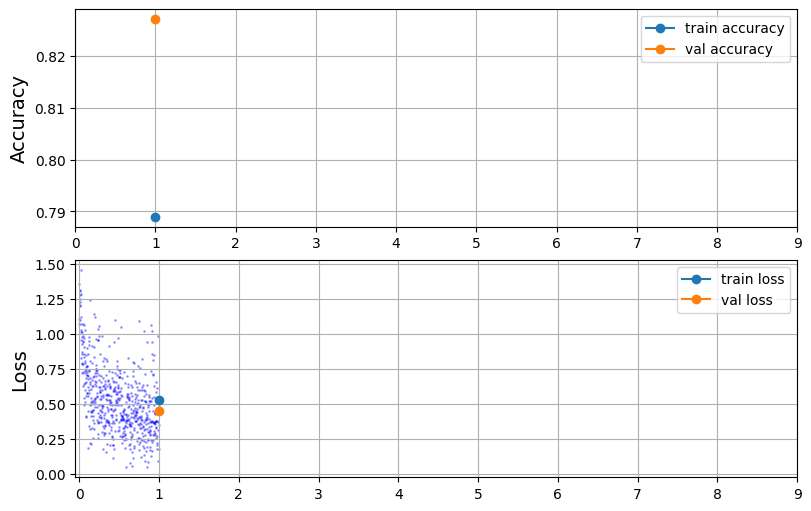


EPOCH 2


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.284 | 89.16
   eval:  0.370 | 85.68
Saved best model: best_model_02


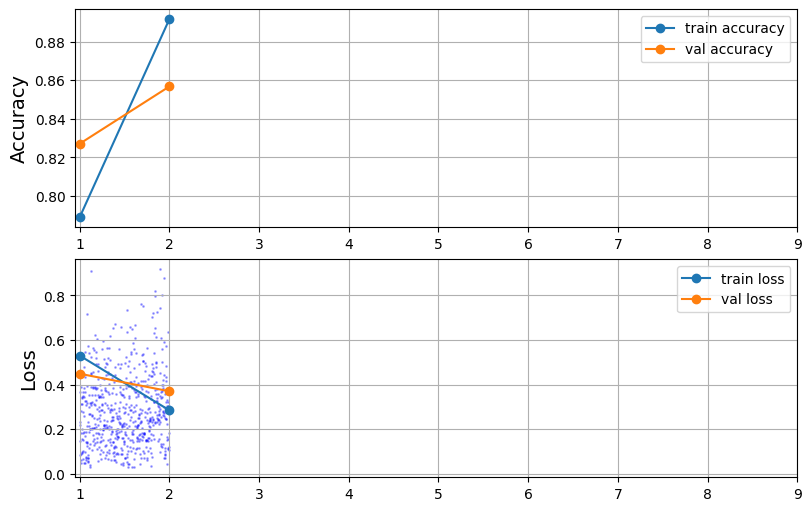


EPOCH 3


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.156 | 94.15
   eval:  0.396 | 85.78
Saved best model: best_model_03


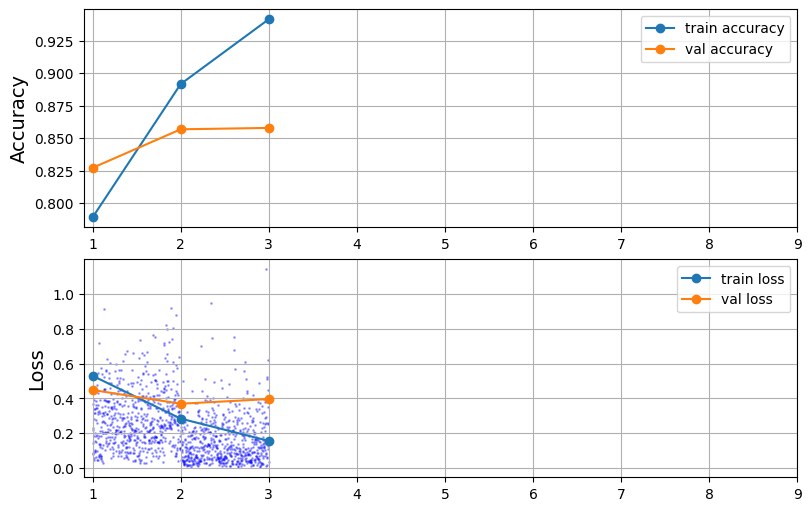

train:   0%|          | 0/621 [00:00<?, ?it/s]


EPOCH 4


val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.092 | 96.57
   eval:  0.535 | 85.71
Early stopping counter: 1/3


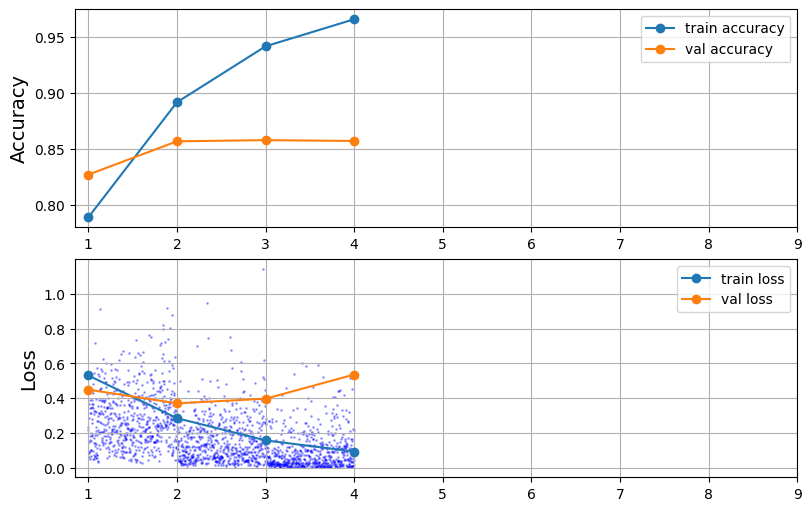


EPOCH 5


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.069 | 97.54
   eval:  0.511 | 85.86
Saved best model: best_model_05


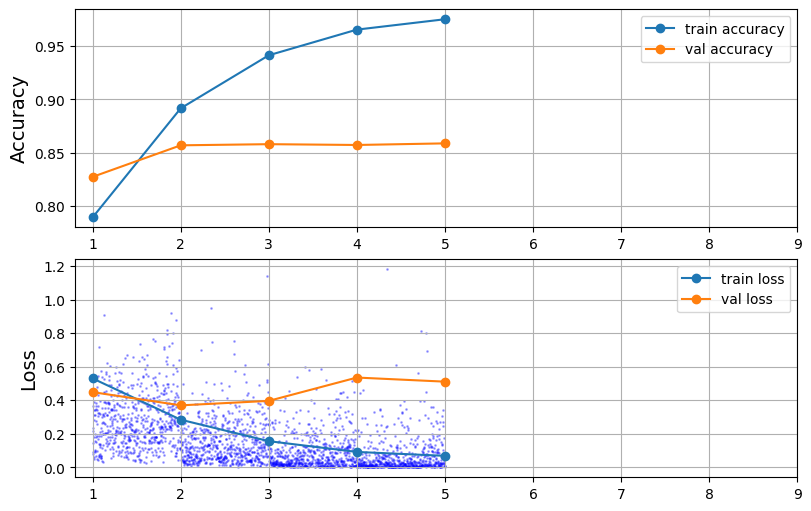


EPOCH 6


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.054 | 98.02
   eval:  0.604 | 85.49
Early stopping counter: 1/3


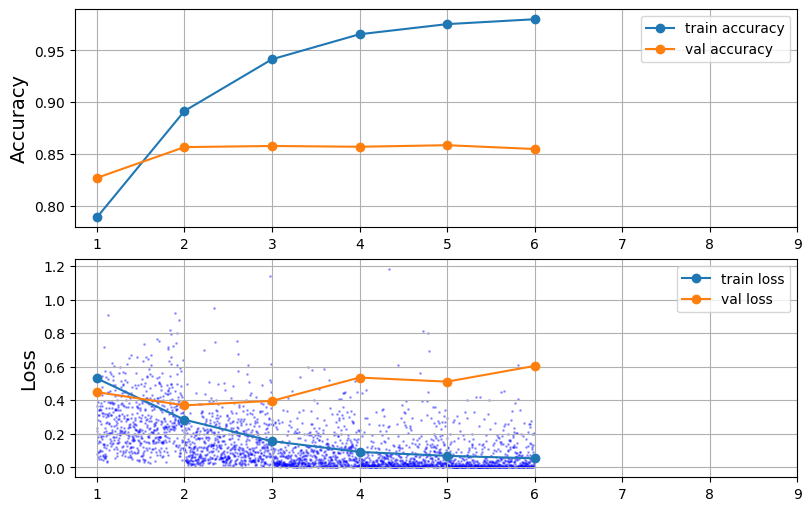


EPOCH 7


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.043 | 98.61
   eval:  0.583 | 85.84
Early stopping counter: 2/3


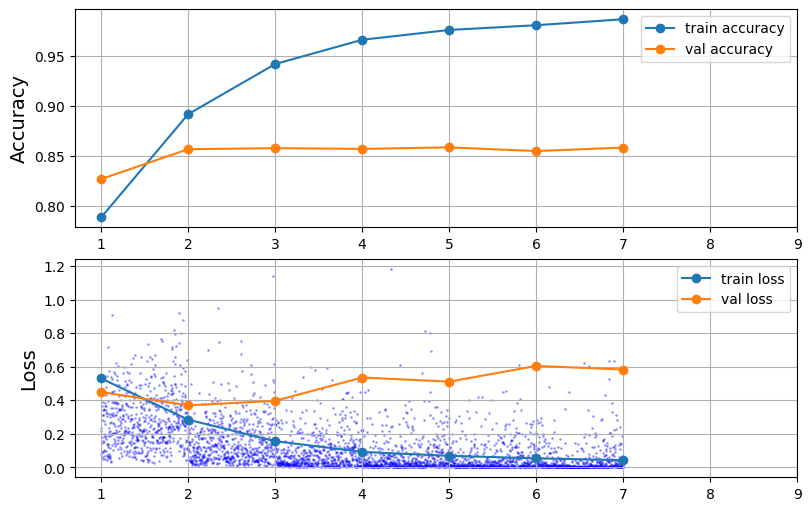


EPOCH 8


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.028 | 99.02
   eval:  0.981 | 81.96
Early stopping counter: 3/3


In [6]:
training.start_new_training()
training.train(epochs=20, patience=3)

In [10]:
training.load_best_model()
test_predictions = training.predict(test_dataset)

Loading model: best_model_05


  0%|          | 0/39 [00:00<?, ?it/s]

In [8]:
def accuracy(output: torch.Tensor, labels: torch.Tensor) -> float:
    if len(output.shape) == 2:
        output = torch.argmax(output, dim=1).flatten()

    labels_flat = labels.flatten()
    return torch.sum(output == labels_flat).item() / len(labels_flat)

test_accuracy = accuracy(test_dataset.tensors[2], torch.tensor(test_predictions))
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.8581


#### Inference

In [9]:
# training.load_best_model()

# train_claims = read_data('raw_data/train_claims.json')
# val_claims = read_data('raw_data/val_claims.json')
# test_claims = read_data('raw_data/test_claims.json')
#
# def build_dataset(claims: QTDataset) -> TensorDataset:
#     # features
#     features = [claim['claim'] for claim in claims]
#     input_tokens = []
#     attention_masks = []
#
#     for feature in tqdm(features):
#         input_token, attention_mask = tokenizer(feature)
#         input_tokens.append(input_token)
#         attention_masks.append(attention_mask)
#
#     input_tokens = torch.cat(input_tokens)
#     attention_masks = torch.cat(attention_masks)
#
#     # labels
#     labels = [claim['taxonomy_label'].strip() for claim in claims]
#     encoded_labels = torch.tensor(label_endocer.transform(labels))
#
#     return TensorDataset(input_tokens, attention_masks, encoded_labels)
#
# train_dataset = build_dataset(train_claims)
# val_dataset = build_dataset(val_claims)
# test_dataset = build_dataset(test_claims)